In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d
from numpy.polynomial.polynomial import Polynomial


Parent_dir = '/data/nas_data/wsy/GW2025/hw2/'
filename = 'Fermi_n9_GRB240219A .txt'
file1 = np.loadtxt(Parent_dir + filename)
time_col = file1[:, 0] - file1[:, 0].min()
energy_col = file1[:, 2]
TIME_BIN_SIZE = 1 #seconds

# return two arrays, including the detrended data and background data
def Detrd(bins, rates, poly_degree):
    pfit = Polynomial.fit(bins, rates, deg=poly_degree)
    background_fit = pfit(bins)
    detrended_rate = rates - background_fit
    return detrended_rate, background_fit

# raw data
time_bins = np.arange(time_col.min(), time_col.max(), TIME_BIN_SIZE)
counts, bin_edges = np.histogram(time_col, bins=time_bins)
count_rate = counts / TIME_BIN_SIZE
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian filter
smoothing_sigma = 3.0
smoothed_counts = gaussian_filter1d(count_rate, sigma=smoothing_sigma)

# Detrend the signal (remove the background)
detrended_smooth, background_smooth = Detrd(bin_centers, smoothed_counts, 3)
detrended_counts, background_counts = Detrd(bin_centers, count_rate, 3)

# Find peaks (FWHM)
peaks, properties = find_peaks(detrended_counts)
main_peak_index = peaks[np.argmax(detrended_counts[peaks])]
FWHM_dix = ((0.5*np.max(detrended_counts) <= detrended_counts) & (detrended_counts <= np.max(detrended_counts)) & (400 < bin_centers) & (bin_centers < 500))

# significance
N_total = np.sum(count_rate[FWHM_dix]) * TIME_BIN_SIZE
N_bkg = np.sum(background_counts[FWHM_dix]) * TIME_BIN_SIZE # the background is obtained via poly fitting
significance = (N_total - N_bkg) / np.sqrt(N_bkg)
print(significance)

print(bin_centers[main_peak_index])

10.220975409443344
456.5


In [40]:
# Find T90
signal_mask = (430 <= bin_centers) & (bin_centers <= 570)
grb_times = bin_centers[signal_mask] - bin_centers[main_peak_index]
grb_counts = count_rate[signal_mask]
grb_smooth = smoothed_counts[signal_mask]

background_mask = ~signal_mask
background_rate = np.mean(count_rate[background_mask])


net_rate = grb_counts - background_rate

net_rate[net_rate < 0] = 0
net_counts = net_rate * TIME_BIN_SIZE
cumulative_counts = np.cumsum(net_counts)
total_fluence = cumulative_counts[-1]

t05_fluence_threshold = 0.05 * total_fluence
t95_fluence_threshold = 0.95 * total_fluence

# 找到累计计数值首次超过阈值的索引
index_t05 = np.searchsorted(cumulative_counts, t05_fluence_threshold)
index_t95 = np.searchsorted(cumulative_counts, t95_fluence_threshold)

    
t05 = grb_times[index_t05]
t95 = grb_times[index_t95]
t90 = t95 - t05



In [41]:
# energy spectrum in T90 range
grb_start = bin_centers[main_peak_index] + t05
grb_end = bin_centers[main_peak_index] + t95

signal_mask = (time_col >= grb_start) & (time_col <= grb_end)
background_mask = ~signal_mask
signal_energies = energy_col[signal_mask]
background_energies = energy_col[background_mask]
# energy bins
energy_bins = np.logspace(np.log10(np.min(energy_col)), np.log10(np.max(energy_col)), 5000) 
energy_bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
# signal spectrum and background spectrum
total_spectrum, _ = np.histogram(signal_energies, bins=energy_bins)
background_spectrum, _ = np.histogram(background_energies, bins=energy_bins)
All_spectrum, _ = np.histogram(energy_col, bins=energy_bins)
# remove the background
signal_duration = grb_end - grb_start
background_duration = time_col.max() - signal_duration
scaling_factor = signal_duration / background_duration
# net spectrum
net_spectrum = total_spectrum - (background_spectrum * scaling_factor)

In [42]:
# hard X ray
hard_x_ray_mask = (energy_col >= 1) & (energy_col <= 100)
hard_x_ray_times = time_col[hard_x_ray_mask]

# Gamma ray
gamma_ray_mask = (energy_col > 100)
gamma_ray_times = time_col[gamma_ray_mask]

# public time bins
common_time_bins = np.arange(time_col.min(), time_col.max(), TIME_BIN_SIZE)
bin_centers_div = (common_time_bins[:-1] + common_time_bins[1:]) / 2
# LC for hard X-ray
hard_x_ray_counts, _ = np.histogram(hard_x_ray_times, bins=common_time_bins)
hard_x_ray_rate = hard_x_ray_counts / TIME_BIN_SIZE
# LC for gamma ray
gamma_ray_counts, _ = np.histogram(gamma_ray_times, bins=common_time_bins)
gamma_ray_rate = gamma_ray_counts / TIME_BIN_SIZE
# 平滑化
smoothing_sigma = 3.0
smoothed_counts_gamma = gaussian_filter1d(gamma_ray_rate, sigma=smoothing_sigma)
smoothed_counts_x = gaussian_filter1d(hard_x_ray_rate, sigma=smoothing_sigma)
#下面是对Gamma波段光变曲线的处理
# Detrend the signal (remove the background)
detrended_smooth_gamma, background_smooth_gamma = Detrd(bin_centers_div, smoothed_counts_gamma, 3)
detrended_counts_gamma, background_counts_gamma = Detrd(bin_centers_div, gamma_ray_rate, 3)
# Find peaks (FWHM)
peaks, properties = find_peaks(detrended_smooth_gamma)
main_peak_index = peaks[np.argmax(detrended_smooth_gamma[peaks])]
FWHM_dix_gm = ((0.5*np.max(detrended_smooth_gamma) <= detrended_smooth_gamma) & (detrended_smooth_gamma <= np.max(detrended_smooth_gamma)) & (400 <= bin_centers_div) & (bin_centers_div <= 500))

# significance
N_total = np.sum(gamma_ray_rate[FWHM_dix_gm]) * TIME_BIN_SIZE
N_bkg = np.sum(background_counts_gamma[FWHM_dix_gm]) * TIME_BIN_SIZE # the background is obtained via poly fitting
significance_gm = (N_total - N_bkg) / np.sqrt(N_bkg)
print(significance_gm)

#下面是对X射线波段光变曲线的处理
# Detrend the signal (remove the background)
detrended_smooth_x, background_smooth_x = Detrd(bin_centers_div, smoothed_counts_x, 3)
detrended_counts_x, background_counts_x = Detrd(bin_centers_div, hard_x_ray_rate, 3)
# Find peaks (FWHM)
peaks, properties = find_peaks(detrended_smooth_x)
main_peak_index = peaks[np.argmax(detrended_smooth_x[peaks])]
FWHM_dix_x = ((0.5*np.max(detrended_smooth_x) <= detrended_smooth_x) & (detrended_smooth_x <= np.max(detrended_smooth_x)) & (400 <= bin_centers_div) & (bin_centers_div <= 500))

# significance
N_total = np.sum(hard_x_ray_rate[FWHM_dix_x]) * TIME_BIN_SIZE
N_bkg = np.sum(background_counts_x[FWHM_dix_x]) * TIME_BIN_SIZE # the background is obtained via poly fitting
significance_x = (N_total - N_bkg) / np.sqrt(N_bkg)
print(significance_x)


4.24379394115122
9.861640566987514


<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:89: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:89: SyntaxWarning: invalid escape sequence '\s'
<>:121: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_304038/706939754.py:23: SyntaxWarning: invalid escape sequence '\s'
  ax2.text(480, 80, f"significance : {significance:.2f}$\sigma$")
/tmp/ipykernel_304038/706939754.py:40: SyntaxWarning: invalid escape sequence '\s'
  ax3.text(80, 160, f"$T_{{90}}$ $\sim $ {t90:.2f} s") # f-string
/tmp/ipykernel_304038/706939754.py:89: SyntaxWarning: invalid escape sequence '\s'
  ax6.text(230, 50, f"significance : {significance_gm:.2f}$\sigma$")
/tmp/ipykernel_304038/706939754.py:121: SyntaxWarning: invalid escape sequence '\s'
  ax8.text(220, 75, f"significance : {significance_x:.2f

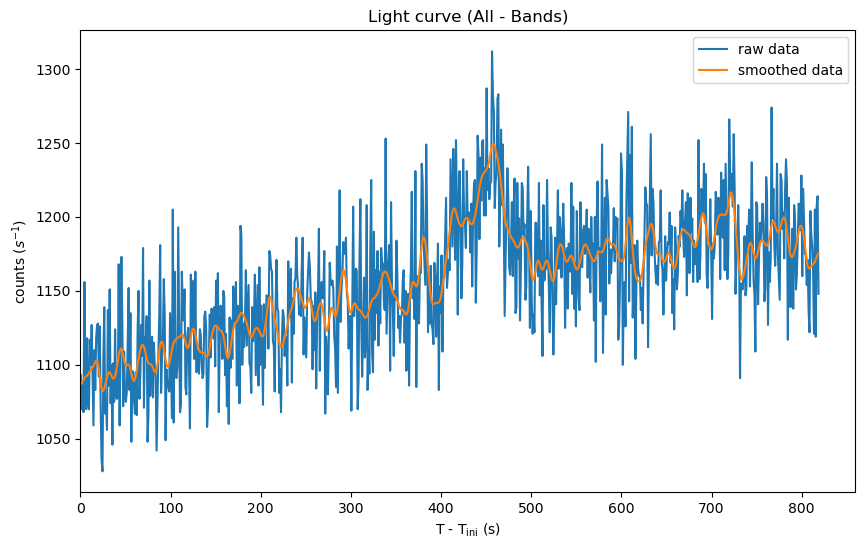

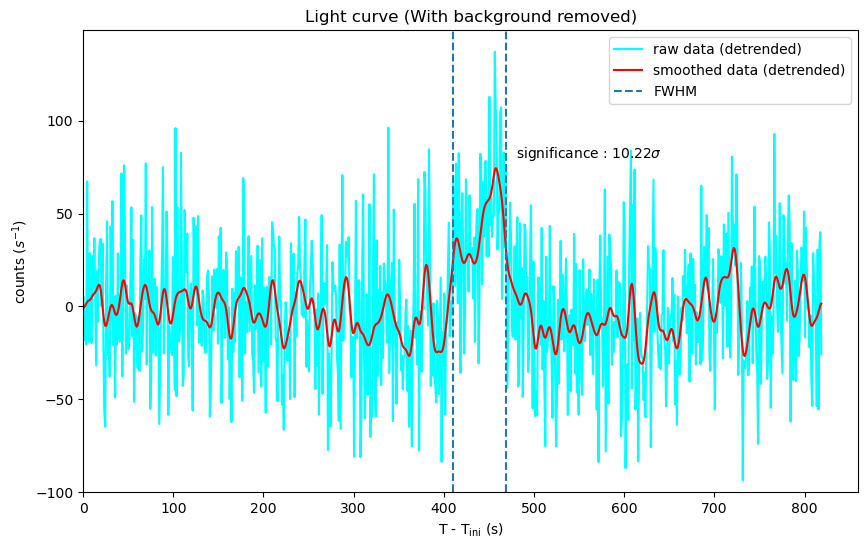

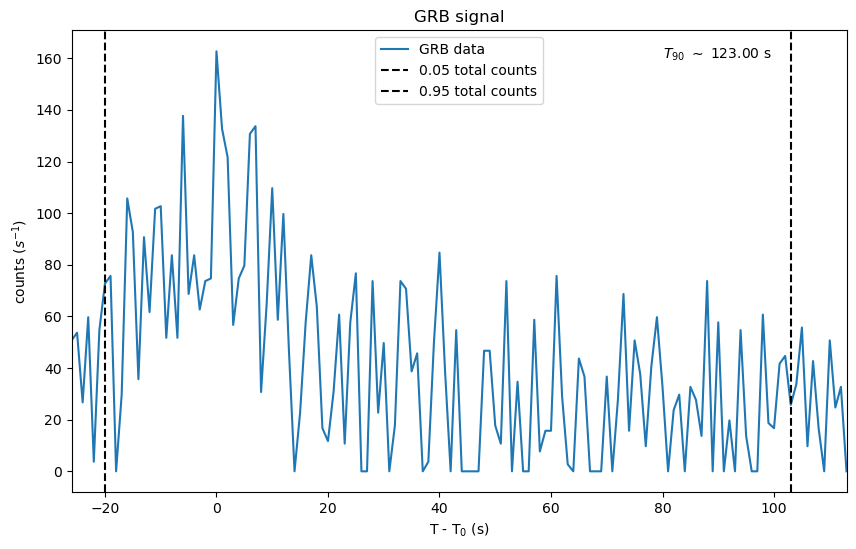

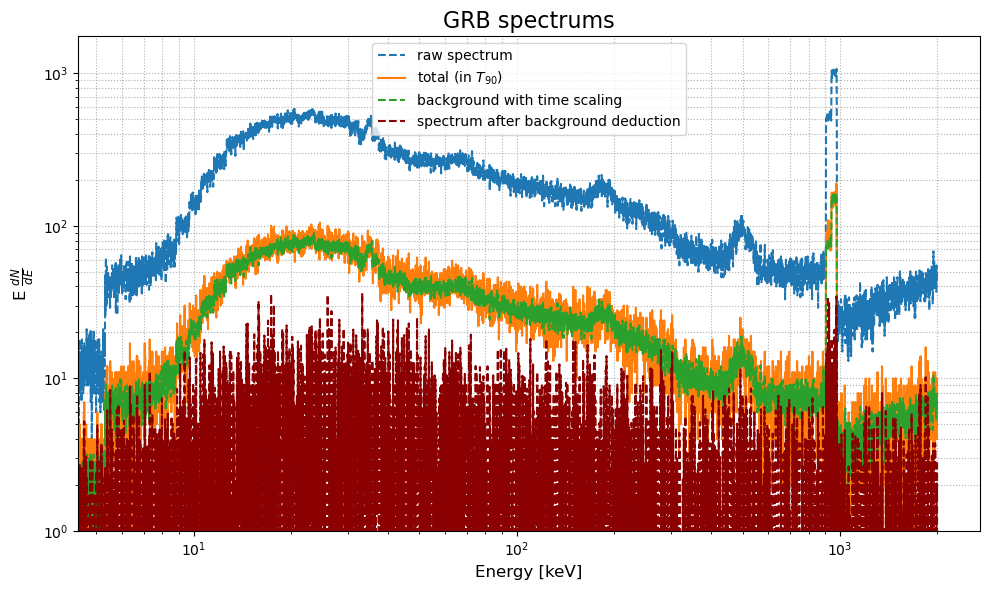

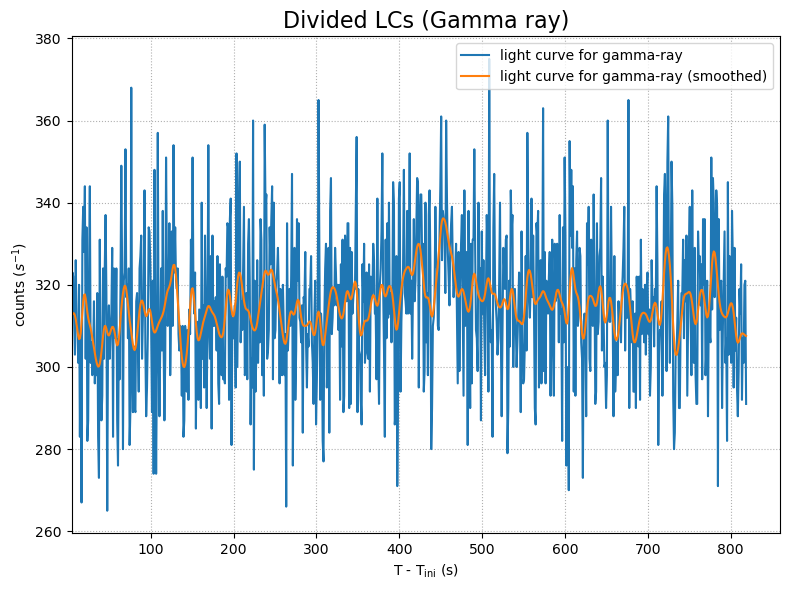

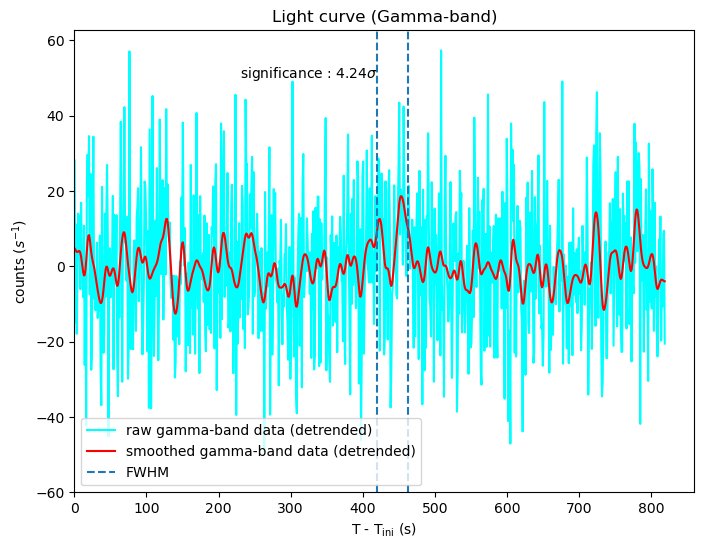

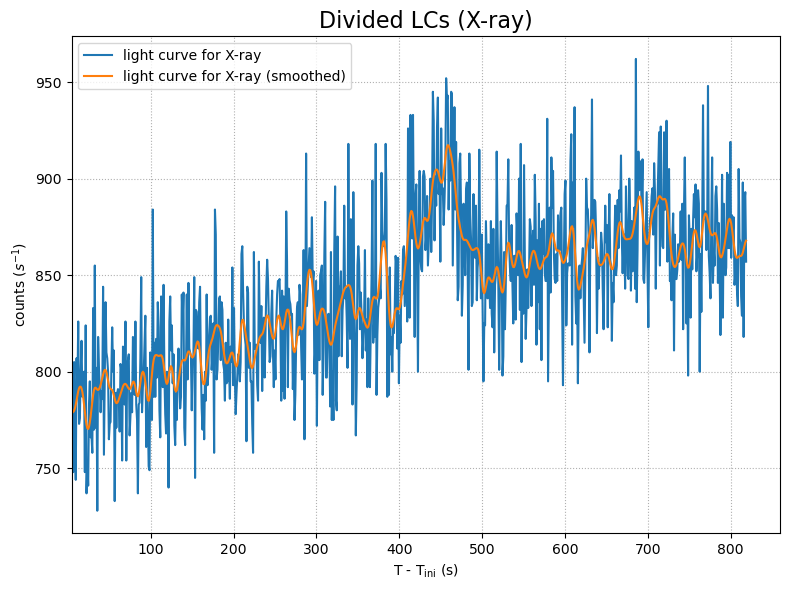

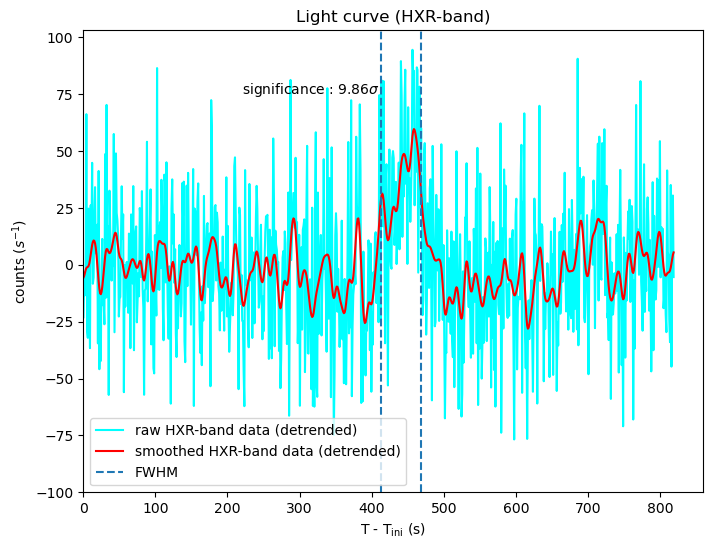

In [43]:
# raw data
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(bin_centers, count_rate, label = 'raw data')
ax1.plot(bin_centers, smoothed_counts, label = 'smoothed data')
ax1.set_title('Light curve (All - Bands)')
ax1.legend()
ax1.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax1.set_ylabel(r'counts ($s^{-1}$)')
ax1.set_xlim(0)
plt.legend()
plt.savefig('Raw_data.pdf', format = 'pdf')
plt.show()

# detrended data
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(bin_centers, detrended_counts, label = 'raw data (detrended)', color = 'cyan')
ax2.plot(bin_centers, detrended_smooth, label = 'smoothed data (detrended)', color = 'r')
ax2.axvline(bin_centers[FWHM_dix].min(), 0, 1, linestyle = '--' , label = 'FWHM')
ax2.axvline(bin_centers[FWHM_dix].max(), 0, 1, linestyle = '--')
ax2.set_title('Light curve (With background removed)')
ax2.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax2.set_ylabel(r'counts ($s^{-1}$)')
ax2.text(480, 80, f"significance : {significance:.2f}$\sigma$")
ax2.set_xlim(0)
ax2.set_ylim(-100)
plt.legend()
plt.savefig('detrended_data.pdf', format = 'pdf')
plt.show()

# GRB section
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(grb_times, net_rate, label = 'GRB data')
#ax3.plot(grb_times, grb_smooth, label = 'smoothed data (detrended)', color = 'r')
ax3.set_title('GRB signal')
ax3.set_xlabel(r'T - $\rm T_{{0}}$ (s)')
ax3.set_ylabel(r'counts ($s^{-1}$)')
ax3.set_xlim(np.min(grb_times), np.max(grb_times))
ax3.axvline(t05,0,1, linestyle = '--', color = 'black', label = '0.05 total counts')
ax3.axvline(t95,0,1, linestyle = '--', color = 'black', label = '0.95 total counts')
ax3.text(80, 160, f"$T_{{90}}$ $\sim $ {t90:.2f} s") # f-string
plt.legend()
plt.savefig('T90.pdf', format = 'pdf')
plt.show()

# energy spectrum
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.set_title("GRB spectrums", fontsize=16)
ax4.plot(energy_bin_centers, All_spectrum, linestyle='--', label='raw spectrum')
ax4.plot(energy_bin_centers, total_spectrum, linestyle='-',label=r'total (in $T_{90}$)')
ax4.plot(energy_bin_centers, background_spectrum* scaling_factor, linestyle='--',label='background with time scaling')
ax4.plot(energy_bin_centers, net_spectrum, linestyle='--', color='darkred', label='spectrum after background deduction')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel("Energy [keV]", fontsize=12)
ax4.set_ylabel(r"E $\frac{dN}{dE}$", fontsize=12)
ax4.grid(True, which="both", linestyle=':')
ax4.set_ylim(1e0)
ax4.set_xlim(np.min(energy_col))
ax4.legend()
plt.savefig('Espectrums.pdf', format = 'pdf')
plt.tight_layout()
plt.show()

# divided LCs
fig5, ax5 = plt.subplots(figsize=(8, 6))
ax5.set_title("Divided LCs (Gamma ray)", fontsize=16)
#ax5.plot(bin_centers_div, hard_x_ray_rate, linestyle='--', label='light curve for X-ray')
ax5.plot(bin_centers_div, gamma_ray_rate, linestyle='-',label = 'light curve for gamma-ray')
ax5.plot(bin_centers_div, smoothed_counts_gamma, linestyle='-',label = 'light curve for gamma-ray (smoothed)')
ax5.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax5.set_ylabel(r'counts ($s^{-1}$)')
ax5.grid(True, which="both", linestyle=':')
#ax5.set_ylim(1e0)
ax5.set_xlim(np.min(energy_col))
ax5.legend()
plt.savefig('LC_gamma.pdf', format = 'pdf')
plt.tight_layout()
plt.show()

# detrended data
fig6, ax6 = plt.subplots(figsize=(8, 6))
ax6.plot(bin_centers_div, detrended_counts_gamma, label = 'raw gamma-band data (detrended)', color = 'cyan')
ax6.plot(bin_centers_div, detrended_smooth_gamma, label = 'smoothed gamma-band data (detrended)', color = 'r')
ax6.axvline(bin_centers_div[FWHM_dix_gm].min(), 0, 1, linestyle = '--' , label = 'FWHM')
ax6.axvline(bin_centers_div[FWHM_dix_gm].max(), 0, 1, linestyle = '--')
ax6.set_title('Light curve (Gamma-band)')
ax6.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax6.set_ylabel(r'counts ($s^{-1}$)')
ax6.text(230, 50, f"significance : {significance_gm:.2f}$\sigma$")
ax6.set_xlim(0)
ax6.set_ylim(-60)
plt.legend()
plt.savefig('detrended_data_gamma.pdf', format = 'pdf')
plt.show()

# divided LCs (x-ray)
fig7, ax7 = plt.subplots(figsize=(8, 6))
ax7.set_title("Divided LCs (X-ray)", fontsize=16)
#ax5.plot(bin_centers_div, hard_x_ray_rate, linestyle='--', label='light curve for X-ray')
ax7.plot(bin_centers_div, hard_x_ray_rate, linestyle='-',label = 'light curve for X-ray')
ax7.plot(bin_centers_div, smoothed_counts_x, linestyle='-',label = 'light curve for X-ray (smoothed)')
ax7.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax7.set_ylabel(r'counts ($s^{-1}$)')
ax7.grid(True, which="both", linestyle=':')
#ax5.set_ylim(1e0)
ax7.set_xlim(np.min(energy_col))
ax7.legend()
plt.savefig('LC_X.pdf', format = 'pdf')
plt.tight_layout()
plt.show()

# detrended data (x-ray)
fig8, ax8 = plt.subplots(figsize=(8, 6))
ax8.plot(bin_centers_div, detrended_counts_x, label = 'raw HXR-band data (detrended)', color = 'cyan')
ax8.plot(bin_centers_div, detrended_smooth_x, label = 'smoothed HXR-band data (detrended)', color = 'r')
ax8.axvline(bin_centers_div[FWHM_dix_x].min(), 0, 1, linestyle = '--' , label = 'FWHM')
ax8.axvline(bin_centers_div[FWHM_dix_x].max(), 0, 1, linestyle = '--')
ax8.set_title('Light curve (HXR-band)')
ax8.set_xlabel(r'T - $\rm T_{\rm ini}$ (s)')
ax8.set_ylabel(r'counts ($s^{-1}$)')
ax8.text(220, 75, f"significance : {significance_x:.2f}$\sigma$")
ax8.set_xlim(0)
ax8.set_ylim(-100)
plt.legend()
plt.savefig('detrended_data_X.pdf', format = 'pdf')
plt.show()